### All Shapes and Colors - Kaggle Challenge ###

In [ ]:
# Imports
import os, ast, random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import matplotlib.pyplot as plt

def seed_everything(seed=17):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
seed_everything(17)

# Device (prototyped on my MacBook Air M1)
device = torch.device(
    "mps" if torch.backends.mps.is_available() else
    ("cuda" if torch.cuda.is_available() else "cpu") # for colab compatibility
)
device

device(type='mps')

After looking at the problem, I can see we have the following constraints:
- Each image contains k objects where 1 <= k <= 9, since there are no duplicate objects with same (shape, color) in any given image.
- we can have multiple of the same shape and multiple of the same color in the image.

I'll want to use a multi-label target over all 9 possible pairs. For each image, the target is a 9-dimension one-hot vector with a one for each present pair in the image.

In [ ]:
SHAPES = ['circle', 'square', 'triangle']
COLORS = ['red', 'green', 'blue']

# assign each (shape, color) pair an index
PAIR_TO_IDX = {
    f"{shape}_{color}": i
    for i, (shape, color) in enumerate(
        (s, c) for s in SHAPES for c in COLORS
    )
}

IDX_TO_PAIR = {v: k for k, v in PAIR_TO_IDX.items()} # need this to decode predictions

print(PAIR_TO_IDX)
print(IDX_TO_PAIR)

{'circle_red': 0, 'circle_green': 1, 'circle_blue': 2, 'square_red': 3, 'square_green': 4, 'square_blue': 5, 'triangle_red': 6, 'triangle_green': 7, 'triangle_blue': 8}
{0: 'circle_red', 1: 'circle_green', 2: 'circle_blue', 3: 'square_red', 4: 'square_green', 5: 'square_blue', 6: 'triangle_red', 7: 'triangle_green', 8: 'triangle_blue'}


Step one is to setup label representation

In [ ]:
# Encoding the pairs to multi-hot vector
def encode_pairs(pairs):
    """
    Encode a list of (shape, color) pairs to a multi-hot vector.
    pairs: list of tuples (shape, color)
    returns: torch tensor of shape (9,)
    """
    target = np.zeros(len(PAIR_TO_IDX), dtype=np.float32)
    for shape, color in pairs:
        shape, color = shape.lower(), color.lower()
        key = f"{shape}_{color}"
        y = PAIR_TO_IDX[key]
        target[y] = 1.0
    target = torch.from_numpy(target)
    return target

# pairs = [("circle","red"), ("triangle","blue")]
# y = encode_pairs(pairs)
# print(y)
# print(y.sum())

def decode_vec(y):
    """
    Decode a multi-hot vector to a list of (shape, color) pairs.
    y: torch tensor of shape (9,)
    returns: list of tuples (shape, color)
    """
    probs = torch.sigmoid(y) # convert logits to probabilities using sigmoid (will give values between 0 and 1)
    idxs = (probs >= 0.5).nonzero(as_tuple=True)[0].tolist() # threshold at 0.5
    pairs = []
    for i in idxs:
        pair = IDX_TO_PAIR[i]
        shape, color = pair.split("_")
        pairs.append((shape, color))
    return pairs


# logits = torch.tensor([3.0, -1.0, 0.2, 0.0, 0.0, 2.5, -2.0, 0.0, 0.0])
# decoded = decode_vec(logits)
# print(decoded)



There's a function to make the data usable for training. I represent the labels as the 9-dim tensor mentioned earlier.

I also have a function to decode the tensor outputted at inference time. It applies a sigmoid to get probabilities, thresholds, then turns the tensor back into (shape, color) tuples.

Next thing to do is load the data.

In [ ]:
def parse_label_string(string): # need this since the CSV has labels as strings
    """
    Parse a label string into a list of (shape, color) pairs.
    string: str, e.g. "[(circle_red), (triangle_blue)]" or "[]"
    returns: list of tuples (shape, color)
    """
    if string == "" or string == "[]" or string is None: #handle null or empty arg
        return []
    s = string.lower().strip()
    data = ast.literal_eval(s) # turn the string into a list of tuples
    # normalize the tuples
    data = [(shape.strip().lower(), color.strip().lower()) for shape, color in data]
    return data

# test parser
# samples = [
#     "[('square', 'blue'), ('circle', 'green'), ('square', 'red')]",
#     "[('circle','blue'),('square','green'),('circle','red'),('square','red')]",
#     "[]"
# ]
# for s in samples:
#     pairs = parse_label_string(s)
#     assert isinstance(pairs, list), "Parser should return a list"
#     for (shape, color) in pairs:
#         assert shape in SHAPES and color in COLORS, f"Bad pair parsed: {(shape,color)}"

Creating dataset classes here. I use pillow to load the images and apply transformations. In this case I'm just doing normalization since the provided images already look like they have distortion and noise applied. No resizing either. I may add image augmentation if validation suggests any overfitting.

In [ ]:
# Datasets
class ShapesColorsDatasetTrain(Dataset):
    """
    Dataset for training and validation: (image_tensor, target_vector)
    CSV columns: image_path, label
    """
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # resolve image path
        rel = str(row["image_path"])
        img_path = rel if os.path.isabs(rel) else os.path.join(self.img_dir, rel)

        # load image with pillow and force rgb color space
        img = Image.open(img_path).convert("RGB")

        # apply any preprocessing transforms
        if self.transform:
            img = self.transform(img)

        # parse and encode label
        pairs = parse_label_string(row["label"])
        target = encode_pairs(pairs)

        # return tensors ready for the model and loss
        return img, target

class ShapesColorsDatasetTest(Dataset):
    """
    Dataset for testing: (image_tensor, image_path)
    CSV column: image_path
    """
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rel = str(self.df.iloc[idx]["image_path"])
        img_path = rel if os.path.isabs(rel) else os.path.join(self.img_dir, rel)

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, rel

# Create datasets using existing classes with index subsets
class IndexedDataset(Dataset):
    def __init__(self, base_dataset, indices):
        self.base_dataset = base_dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.base_dataset[self.indices[idx]]

Transforms and loaders. I'm using a batch size of 32, shuffling for training, and numworkers = 2. I set numworkers to 0 while working on my Mac, but I'll bring those back if I move to a Colab env. Seems like this dataset is small enough that my M1 should be okay.

Total training samples: 5000
Train split: 4000, Val split: 1000
Datasets created - Train: 4000, Val: 1000, Test: 1000


/Users/omediratta/miniconda3/envs/kodiak_kaggle_vision/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


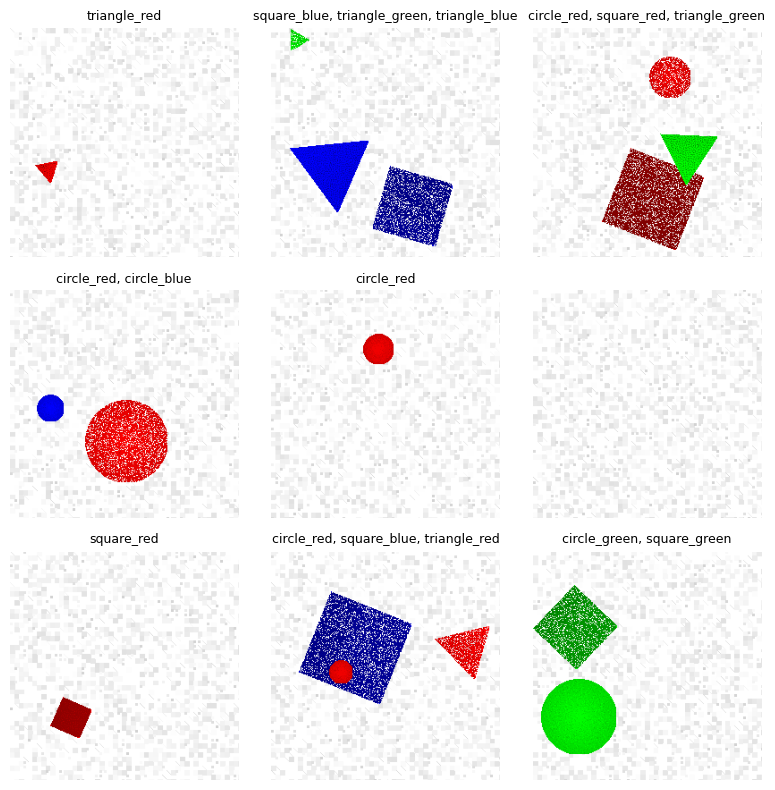

In [ ]:
BATCH_SIZE = 32

# File paths
train_csv = "all-shapes-and-colors-v-2/dataset_v3/train.csv"
test_csv = "all-shapes-and-colors-v-2/dataset_v3/test.csv"
train_img_dir = "all-shapes-and-colors-v-2/dataset_v3"
test_img_dir = "all-shapes-and-colors-v-2/dataset_v3"

# Load and split training data
train_df = pd.read_csv(train_csv)
np.random.seed(17)
indices = np.random.permutation(len(train_df))
split_idx = int(0.8 * len(indices)) # 80 20 split ratio for the training and validation sets
train_indices, val_indices = indices[:split_idx], indices[split_idx:]

print(f"Total training samples: {len(train_df)}")
print(f"Train split: {len(train_indices)}, Val split: {len(val_indices)}")

# Transforms
train_tfms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
val_tfms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create base training dataset and split it
full_train_ds = ShapesColorsDatasetTrain(train_csv, train_img_dir, transform=train_tfms)
train_ds = IndexedDataset(full_train_ds, train_indices)

full_val_ds = ShapesColorsDatasetTrain(train_csv, train_img_dir, transform=val_tfms)
val_ds = IndexedDataset(full_val_ds, val_indices)

test_ds = ShapesColorsDatasetTest(test_csv, test_img_dir, transform=val_tfms)

# Create DataLoaders
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"Datasets created - Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

#test the dataset
# x0, y0 = train_ds[0]
# print("image:", x0.shape)
# print("target:", y0)
# print("num objects:", int(y0.sum().item()))

# sanity check dataloader
def unnorm(x):
    # invert normalize back to [0,1] for display
    return (x * 0.5 + 0.5).clamp(0, 1)

images, targets = next(iter(train_loader))

plt.figure(figsize=(8, 8))
for i in range(min(9, images.size(0))):
    plt.subplot(3, 3, i+1)
    img = unnorm(images[i]).permute(1, 2, 0).numpy()
    plt.imshow(img)
    idxs = (targets[i] > 0.5).nonzero(as_tuple=True)[0].tolist()
    labels = [IDX_TO_PAIR[j] for j in idxs]
    plt.title(", ".join(labels), fontsize=9)
    plt.axis("off")
plt.tight_layout(); plt.show()

Onto the model. I used a small, modern CNN architecture with global average pooling. So my blocks have convolutions, batch normalization, ReLU, and then pooling. I have four of these blocks and then a global average pool before the final linear layer with the 9 logits.

For loss, I've got a multi-label BCEWithLogitsLoss, which compares the 9 logits against the 9-dimensional one-hot target.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class MyCNN(nn.Module):
    """
    Small, stable CNN for multi-label (9 outputs).
    256x256 - 128 - 64 - 32 - 16 after 4 max-pools.
    GAP removes size dependence and keeps params small.
    """
    def __init__(self, num_out=9):
        super().__init__()
        def block(c_in, c_out):
            return nn.Sequential(
                nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )
        self.features = nn.Sequential(
            block(3,   32),  # 256 to 128
            block(32,  64),  # 128 to  64
            block(64, 128),  #  64 to  32
            block(128,256),  #  32 to  16
        )
        self.gap  = nn.AdaptiveAvgPool2d(1) # [B,256,16,16] to [B,256,1,1]
        self.head = nn.Linear(256, num_out) # 9 logits (no sigmoid)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x).flatten(1)
        return self.head(x)

model = MyCNN(num_out=9).to(device)
sum(p.numel() for p in model.parameters())

criterion = nn.BCEWithLogitsLoss()  # multi-label

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3, # conventional learning rate for Adam
    weight_decay=1e-4   # L2 regularization
)

# training epoch function
def train_one_epoch(loader):
    model.train()
    running_loss, n = 0.0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        loss = criterion(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        n += images.size(0)
    return running_loss / n  # average loss

#validation epoch function
def validate_one_epoch(loader):
    model.eval()
    running_loss, n = 0.0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        loss = criterion(logits, targets)
        running_loss += loss.item() * images.size(0)
        n += images.size(0)
    return running_loss / n

EPOCHS = 12
best_val = float("inf")

for epoch in range(1, EPOCHS+1):
    train_loss = train_one_epoch(train_loader)
    val_loss   = validate_one_epoch(val_loader)

    print(f"Epoch {epoch:02d} | train_loss {train_loss:.4f} | val_loss {val_loss:.4f}")

    # save best by val loss
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_tinyscnn.pt")

KeyboardInterrupt: 

After 12 epochs of training, I found that epoch 11 was the best by val_loss. The volatility with val_loss is due to the small validation sets and binary cross entropy. I still got strong minima with epochs 7 and 11. I could turn down the LR for a steadier curve, or switch batchnorm to groupnorm, but none of that is required to finish. Finally, I'll run inference to generate my submission for the Kaggle competition.

In [18]:
# Recreate the model exactly as trained and load weights. This is using the best model saved by val_loss.
model = MyCNN(num_out=9).to(device)
state = torch.load("best_tinyscnn.pt", map_location=device)
model.load_state_dict(state)
model.eval()

def decode_logits_to_pairs(logits_row, thresh=0.5):
    """
    Logits (9,) to list of (shape, color) tuples using a probability threshold.
    """
    probs = torch.sigmoid(logits_row)
    idxs = (probs > thresh).nonzero(as_tuple=True)[0].tolist()
    pairs = []
    for i in idxs:
        pair = IDX_TO_PAIR[i]
        shape, color = pair.split("_")
        pairs.append((shape, color))
    return pairs

def format_pairs_python_literal(pairs):
    """
    Make strings like: "[('circle', 'red'), ('square', 'blue')]".
    """
    if not pairs:
        return "[]"
    inner = ", ".join([f"('{s}', '{c}')" for (s, c) in pairs])
    return f"[{inner}]"

rows = []
with torch.no_grad():
    model.eval()
    for images, paths in test_loader:   
        images = images.to(device)
        logits = model(images)  # [B, 9]
        for i in range(logits.size(0)):
            pairs = decode_logits_to_pairs(logits[i], thresh=0.5)
            label_str = format_pairs_python_literal(pairs)
            rows.append({"path": paths[i], "label": label_str})

submission = pd.DataFrame(rows, columns=["path", "label"])
print(submission.head())  # sanity check
submission.to_csv("submission.csv", index=False)
print("Wrote submission.csv")


/Users/omediratta/miniconda3/envs/kodiak_kaggle_vision/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                     path                                              label
0  test_dataset/img_0.png  [('circle', 'red'), ('square', 'red'), ('squar...
1  test_dataset/img_1.png           [('circle', 'red'), ('square', 'green')]
2  test_dataset/img_2.png  [('circle', 'red'), ('circle', 'green'), ('squ...
3  test_dataset/img_3.png  [('circle', 'blue'), ('square', 'green'), ('tr...
4  test_dataset/img_4.png                              [('square', 'green')]
Wrote submission.csv


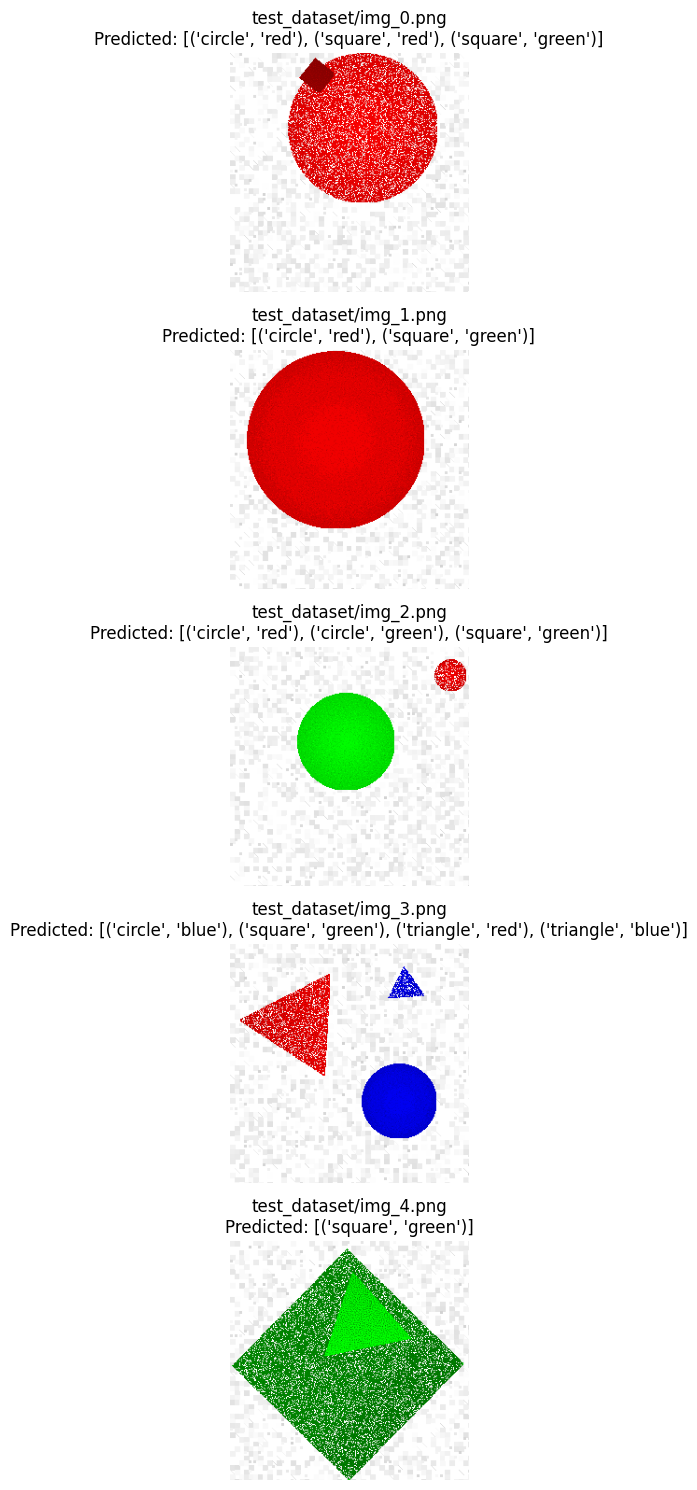

In [ ]:
def show_predictions(dataset, submission_df, n=5):
    """
    Show n test images with their predicted labels (from submission_df).
    """
    plt.figure(figsize=(12, 3*n))
    for i in range(n):
        img, path = dataset[i]  # test_ds should return (image_tensor, path)
        img_np = img.permute(1, 2, 0).numpy()
        img_np = (img_np * 0.5 + 0.5).clip(0, 1)  # unnormalize if mean=0.5,std=0.5

        # find corresponding row in submission
        label_str = submission_df.loc[submission_df["path"] == path, "label"].values[0]

        ax = plt.subplot(n, 1, i+1)
        ax.imshow(img_np)
        ax.set_title(f"{path}\nPredicted: {label_str}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Example: show 5 test samples
show_predictions(test_ds, submission, n=5)


I notice that many of my predictions seem to have [('square', 'green')] light up. An easy, no-retrain fix for this is to use per-class thresholds. I also ran the below cell to check and see if green squares were more frequent in the dataset.

Class frequencies in training data:
triangle_red: 1024 (0.205)
square_red: 1015 (0.203)
square_green: 979 (0.196)
square_blue: 978 (0.196)
triangle_green: 978 (0.196)
triangle_blue: 971 (0.194)
circle_green: 970 (0.194)
circle_red: 958 (0.192)
circle_blue: 952 (0.190)

Per-class thresholds:
circle_red: 0.488
circle_green: 0.495
circle_blue: 0.485
square_red: 0.518
square_green: 0.499
square_blue: 0.499
triangle_red: 0.522
triangle_green: 0.499
triangle_blue: 0.495


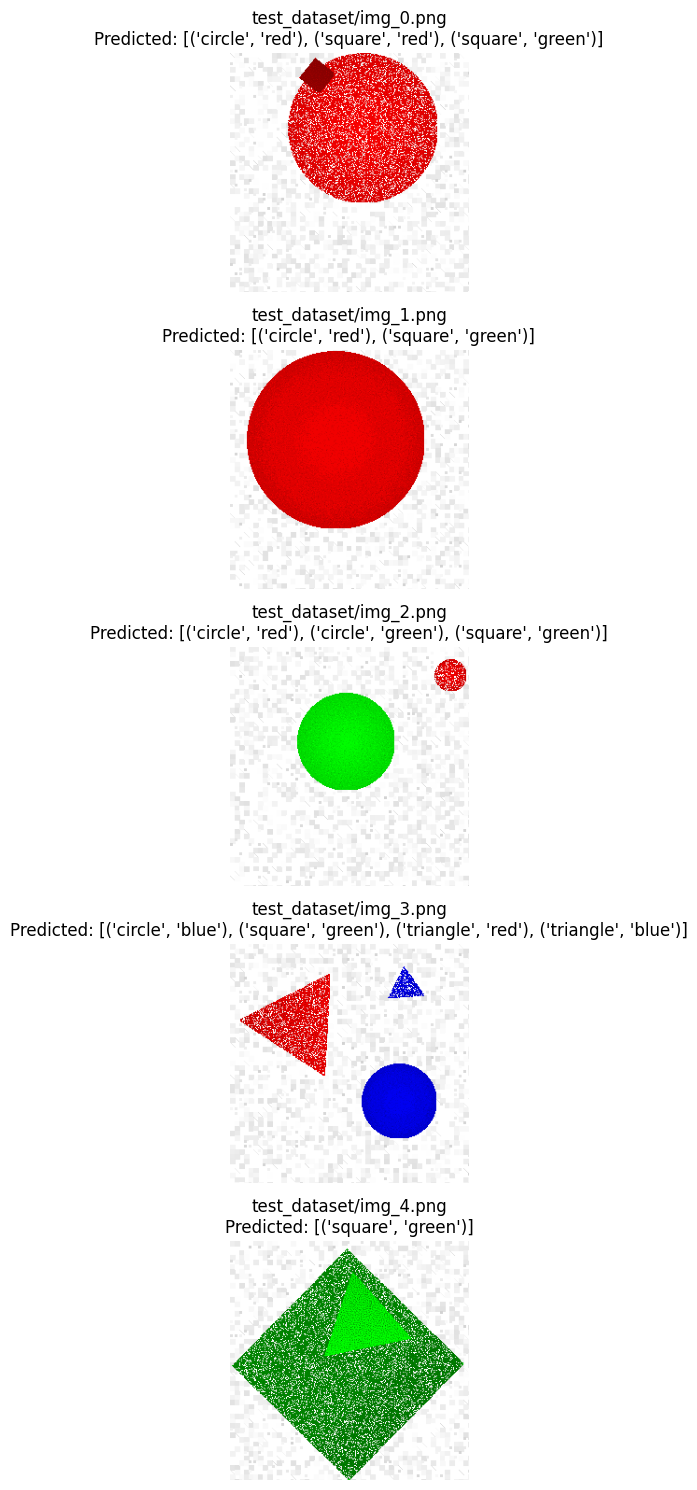

In [21]:
# Check class frequency in training data
pair_counts = {pair: 0 for pair in PAIR_TO_IDX.keys()}

for idx in range(len(train_df)):
    label_str = train_df.iloc[idx]["label"]
    pairs = parse_label_string(label_str)
    for shape, color in pairs:
        key = f"{shape}_{color}"
        pair_counts[key] += 1

print("Class frequencies in training data:")
total_samples = len(train_df)
for pair, count in sorted(pair_counts.items(), key=lambda x: x[1], reverse=True):
    freq = count / total_samples
    print(f"{pair}: {count} ({freq:.3f})")

# calculate per-class thresholds based on frequency
# more frequent classes get higher thresholds to reduce false positives
frequencies = np.array([pair_counts[IDX_TO_PAIR[i]] for i in range(9)]) / total_samples
base_thresh = 0.5
# adjust thresholds: frequent classes get higher thresholds
freq_multiplier = frequencies / frequencies.mean()
per_class_thresholds = base_thresh * freq_multiplier
per_class_thresholds = np.clip(per_class_thresholds, 0.3, 0.8)  # reasonable bounds

print(f"\nPer-class thresholds:")
for i, thresh in enumerate(per_class_thresholds):
    pair = IDX_TO_PAIR[i]
    print(f"{pair}: {thresh:.3f}")

# function to decode using per-class thresholds
def decode_logits_adaptive(logits_row, thresholds):
    """
    Decode logits using per-class thresholds.
    """
    probs = torch.sigmoid(logits_row)
    pairs = []
    for i, (prob, thresh) in enumerate(zip(probs, thresholds)):
        if prob > thresh:
            pair = IDX_TO_PAIR[i]
            shape, color = pair.split("_")
            pairs.append((shape, color))
    return pairs

# generate new submission with adaptive thresholds
rows_adaptive = []
with torch.no_grad():
    model.eval()
    for images, paths in test_loader:   
        images = images.to(device)
        logits = model(images)  # [B, 9]
        for i in range(logits.size(0)):
            pairs = decode_logits_adaptive(logits[i], per_class_thresholds)
            label_str = format_pairs_python_literal(pairs)
            rows_adaptive.append({"path": paths[i], "label": label_str})

submission_adaptive = pd.DataFrame(rows_adaptive, columns=["path", "label"])
submission_adaptive.to_csv("submission.csv", index=False)

# Example: show 5 test samples
show_predictions(test_ds, submission, n=5)

Not seeing an improvement. There are a number of other solutions I could try, but I'll call it here. 